In [1]:
import pandas as pd
import sqlite3
import numpy as np
import math

In [2]:
conn = sqlite3.connect("/Users/kevinmcpherson/pathcheck/latlongdata.sql.db")

In [3]:
cur = conn.cursor()

In [4]:
cur.execute("SELECT name FROM sqlite_master WHERE type = 'table'").fetchall()

[('data_for_feeding_to_the_model',)]

In [5]:
execute_command = cur.execute("SELECT * FROM data_for_feeding_to_the_model").fetchall()

In [6]:
print(execute_command)

[('index', 'longitude', 'latitude'), ('0', '-71.04041', '42.33126'), ('1', '-71.11302', '42.2886'), ('2', '-71.11225', '42.28982'), ('3', '-71.08505', '42.34552'), ('4', '-71.12941', '42.2363'), ('5', '-71.06426', '42.37893'), ('6', '-71.0806', '42.2994'), ('7', '-71.15783', '42.29001'), ('8', '-71.05025', '42.33788'), ('9', '-71.14355', '42.2914'), ('10', '-71.0791', '42.29326'), ('11', '-71.15479', '42.348486'), ('12', '-71.11191', '42.24752'), ('13', '-71.12951', '42.28844'), ('14', '-71.16973', '42.35466'), ('15', '-71.0550316', '42.3594699'), ('16', '-71.0877', '42.27573'), ('17', '-71.07213', '42.35306'), ('18', '-71.07712', '42.29655'), ('19', '-71.08135', '42.30327'), ('20', '-71.16981', '42.28692'), ('21', '-71.047823', '42.286476'), ('22', '-71.06235', '42.315992'), ('23', '-71.08472', '42.28941'), ('24', '-71.12154', '42.24674'), ('25', '-71.105178', '42.330817'), ('26', '-71.10589', '42.26676'), ('27', '-71.11734', '42.27557'), ('28', '-71.06567', '42.31939'), ('29', '-71.0

In [7]:
df = pd.read_sql_query("SELECT * FROM data_for_feeding_to_the_model", conn, index_col = 'index')
df = df.iloc[1:]
df['lat'] = df['lat'].astype('float')
df['long'] = df['long'].astype('float')
df = df.reset_index()
df = df.drop(index=[36,46,47])
df = df.drop(columns = ['index'])
df

,lat,long
0,-71.040410,42.331260
1,-71.113020,42.288600
2,-71.112250,42.289820
3,-71.085050,42.345520
4,-71.129410,42.236300
5,-71.064260,42.378930
6,-71.080600,42.299400
7,-71.157830,42.290010
8,-71.050250,42.337880
9,-71.143550,42.291400


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47 entries, 0 to 49
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lat     47 non-null     float64
 1   long    47 non-null     float64
dtypes: float64(2)
memory usage: 1.1 KB


In [9]:
# Parameters

city = 'Boston'
neighborhood = 'Government Center'
population_density = 12932

# Hypotheticals

patient_age = 65
age_multiplier = 0.5 # ranges from 0 to 1 where 1 is only age pop density, and 0 is only total population density
c = 2 # magnitude of overall skew between lat/long

average_population_density_usa = 33.86 #macrotrends
patient_block_pop_density = 4864.88720 #city_data (people/km^2)

average_age_group_pop_density = 38.1 #wiki
patient_age_group_pop_density = 16.2 #worldbank

In [10]:
# Step 1: Make population density estimate for age and population multipliers

abpdm = average_age_group_pop_density / patient_age_group_pop_density
tpdm = average_population_density_usa / patient_block_pop_density

In [11]:
# Step 2: Combined multiplier

cm = age_multiplier * abpdm + (1-age_multiplier) * tpdm

# Step 3: overall anonymization multiplier

overall_multiplier = c * ((age_multiplier*abpdm + (1-age_multiplier)*tpdm))

In [12]:
overall_multiplier

5.296199677938809

In [13]:
# Gaussian skew

import random
import statistics

mu_lat = df['lat'].mean()
mu_long = df['long'].mean()

sigma_lat = df['lat'].std()
sigma_long = df['long'].std()

rand_gauss_lat = random.gauss(mu_lat,sigma_lat)
rand_gauss_long = random.gauss(mu_long, sigma_long)

In [14]:
def gaussian_blur(x, mu, sigma):
    
    g = (1/((2*math.pi*(sigma))**2))**(-(x**2+mu**2)/(2*sigma)**2)
    
    print(round(g,5))
    

In [15]:
gaussian_blur(-71,mu_lat,sigma_lat)

0.0


In [16]:
from sklearn.preprocessing import PowerTransformer
from matplotlib import pyplot

power = PowerTransformer(method='yeo-johnson', standardize=True)
data_trans = power.fit_transform(df)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


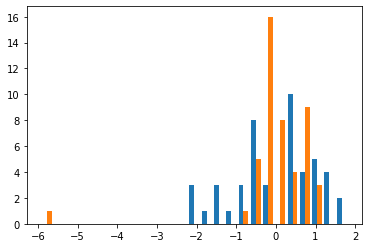

In [17]:
pyplot.hist(data_trans, bins=25)
pyplot.show()

In [18]:
data_trans

array([[ 1.59889344,  0.41597819],
       [-0.38194659, -0.15223948],
       [-0.36061447, -0.13671236],
       [ 0.37991496,  0.61799798],
       [-0.82687374, -0.78048175],
       [ 0.94775577,  1.11660473],
       [ 0.50079699, -0.01334072],
       [-1.59787762, -0.13429049],
       [ 1.33071817,  0.50898331],
       [-1.21186777, -0.11654202],
       [ 0.54244542, -0.092708  ],
       [-1.51559658,  0.66081061],
       [-0.35147213, -0.65167555],
       [-0.82992118, -0.15427276],
       [-1.92090692,  0.75082039],
       [ 1.19967799,  0.82178611],
       [ 0.30779207, -0.31354688],
       [ 0.7324029 ,  0.72737801],
       [ 0.59628364, -0.05031266],
       [ 0.48048068,  0.03723228],
       [-1.92192274, -0.17355362],
       [ 1.39674618, -0.17917361],
       [ 0.99956235,  0.20652002],
       [ 0.3890573 , -0.1419351 ],
       [-0.6135525 , -0.66073233],
       [-0.16862536,  0.40980216],
       [-0.18792585, -0.42332639],
       [-0.49876536, -0.31552391],
       [ 0.90813897,

In [19]:
df = pd.DataFrame(data_trans)
df.columns = ['trans_lat', 'trans_long']

In [20]:
df['multi_lat'] = overall_multiplier*df['trans_lat']
df['multi_long'] = overall_multiplier*df['trans_long']

In [21]:
df.head()

,trans_lat,trans_long,multi_lat,multi_long
0,1.598893,0.415978,8.468059,2.203104
1,-0.381947,-0.152239,-2.022865,-0.806291
2,-0.360614,-0.136712,-1.909886,-0.724056
3,0.379915,0.617998,2.012105,3.273041
4,-0.826874,-0.780482,-4.379288,-4.133587


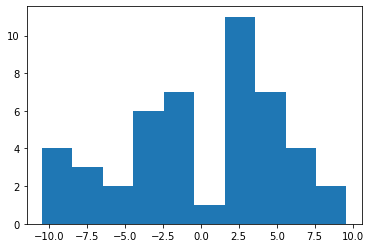

In [24]:
pyplot.hist(df['multi_lat'])
pyplot.show()

In [28]:
from scipy.stats import shapiro

data = np.array(df['multi_lat'])
statistic, pvalue = shapiro(data)
print('statistic = %.3f, p=%.3f\n' % (statistic, pvalue))
if pvalue > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')

statistic = 0.961, p=0.118

Probably Gaussian


In [29]:
from scipy.stats import shapiro

data = np.array(df['multi_long'])
statistic, pvalue = shapiro(data)
print('statistic = %.3f, p=%.3f\n' % (statistic, pvalue))
if pvalue > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')

statistic = 0.581, p=0.000

Probably not Gaussian


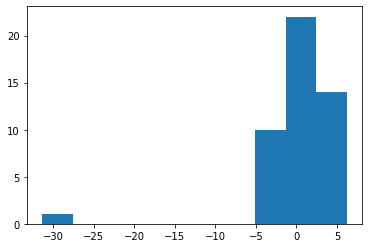

In [30]:
pyplot.hist(df['multi_long'])
pyplot.show()

In [32]:
# local population density (city_data) * area (city_data) * probability = k-anonymity 

# Example spatial k-anonymity

one_std = patient_block_pop_density * 0.01313 * 0.6827
two_std = patient_block_pop_density * 0.01313 * 0.9545
three_std = patient_block_pop_density * 0.01313 * 0.9973

In [33]:
one_std

0.10308428649999998

In [34]:
two_std

0.1441247275

In [35]:
three_std

0.1505873135